In [1]:
import tensorflow as tf
import numpy as np
import glob
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from deeplab import DeepLabV3Plus
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, LearningRateScheduler
%matplotlib inline

2024-03-05 17:48:00.314985: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-05 17:48:01.087224: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
img = glob.glob('./images/train/*/*.png')
label = [path.replace('images', 'gtFine').replace('_leftImg8bit.png', '_gtFine_labelTrainIds.png') for path in img]

index = np.random.permutation(len(img))
img = np.array(img)[index]
label = np.array(label)[index]

img_val = glob.glob('./images/val/*/*.png')
label_val = [path.replace('images', 'gtFine').replace('_leftImg8bit.png', '_gtFine_labelTrainIds.png') for path in img_val]

train_count = len(label)
val_count = len(label_val)

dataset_train = tf.data.Dataset.from_tensor_slices((img, label))
dataset_val = tf.data.Dataset.from_tensor_slices((img_val, label_val))

2024-03-05 17:48:02.275538: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-05 17:48:02.284582: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-05 17:48:02.284874: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

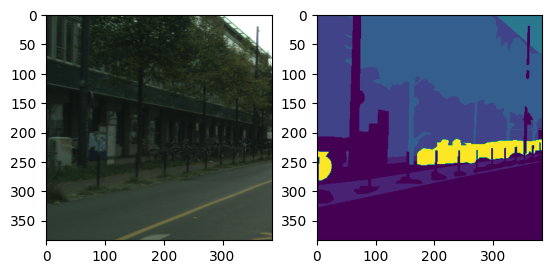

In [3]:
def read_png(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    return img

def read_png_label(path):
    with tf.device('/cpu:0'): 
        img = tf.io.read_file(path)
        img = tf.image.decode_png(img, channels=1)
        img = tf.where(img == 255, tf.zeros_like(img), img)
    return img

def crop_img(img, mask):

    # 确保float32类型
    img_uint8 = tf.cast(img, tf.uint8)

    concat_img = tf.concat([img_uint8, mask], axis=-1)
    concat_img = tf.image.resize(concat_img, (512, 1024), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    crop_img = tf.image.random_crop(concat_img, [384, 384, tf.shape(concat_img)[-1]])

    # 将裁剪后的图像和掩码分离，并将掩码转换回原始数据类型
    return crop_img[:, :, :3], tf.cast(crop_img[:, :, 3:], mask.dtype)



img_1 = read_png(img[0])
label_1 = read_png_label(label[0])
concat_img = tf.concat([img_1, label_1], axis=-1)
img_1, label_1 = crop_img(img_1, label_1)

plt.subplot(1,2,1)
plt.imshow(img_1.numpy())
plt.subplot(1,2,2)
plt.imshow(np.squeeze(label_1.numpy()))

In [4]:
def normal(img, mask):
    img = tf.cast(img, tf.float32)/127.5 -1
    mask = tf.cast(mask, tf.int32)
    return img, mask

def load_image_train(img_path, mask_path):
    img = read_png(img_path)
    mask = read_png_label(mask_path)
    
    # 现有的色彩增强
    # img = tf.image.random_brightness(img, max_delta=0.5)
    img = tf.image.random_saturation(img, lower=0.5, upper=1.5)
    img = tf.image.random_hue(img, max_delta=0.2)
    img = tf.image.random_contrast(img, lower=0.5, upper=1.5)
    img = tf.clip_by_value(img, 0, 255)
    
    # 随机缩放
    scale = tf.random.uniform([], 0.7, 2)
    new_height = tf.cast(tf.cast(tf.shape(img)[0], tf.float32) * scale, tf.int32)
    new_width = tf.cast(tf.cast(tf.shape(img)[1], tf.float32) * scale, tf.int32)
    img = tf.image.resize(img, [new_height, new_width])
    mask = tf.image.resize(mask, [new_height, new_width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

    img, mask = crop_img(img, mask)
    
    # 随机水平翻转
    if tf.random.uniform(()) > 0.5:
        img = tf.image.flip_left_right(img)
        mask = tf.image.flip_left_right(mask)

    # 随机旋转 [0, 90, 180, 270] 度
    # k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    # img = tf.image.rot90(img, k)
    # mask = tf.image.rot90(mask, k)

    # 标准化
    img, mask = normal(img, mask)

    return img, mask


def load_image_val(img_path, mask_path):
    img = read_png(img_path)
    mask = read_png_label(mask_path)
    
    img, mask = crop_img(img, mask)
        
    img, mask = normal(img, mask)
    
    return img, mask

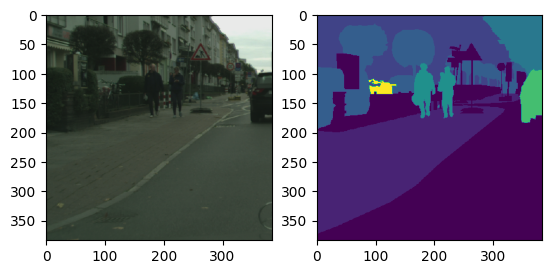

In [5]:
BCTCH_SIZE = 24
BUFFER_SIZE = 128
step_per_epoch = train_count//BCTCH_SIZE
val_step = val_count//BCTCH_SIZE

auto = tf.data.experimental.AUTOTUNE
dataset_train = dataset_train.map(load_image_train, num_parallel_calls=auto)
dataset_val = dataset_val.map(load_image_val, num_parallel_calls=auto)

for i, m in dataset_train.take(1):
    plt.subplot(1,2,1)
    plt.imshow((i.numpy() + 1)/2)
    plt.subplot(1,2,2)
    plt.imshow(np.squeeze(m.numpy()))

dataset_train = dataset_train.shuffle(BUFFER_SIZE).batch(BCTCH_SIZE)
dataset_val = dataset_val.batch(BCTCH_SIZE)

In [6]:
dataset_train

<_BatchDataset element_spec=(TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 384, 384, 1), dtype=tf.int32, name=None))>

In [7]:
model = DeepLabV3Plus(384, 384, 11)

*** Building DeepLabv3Plus Network ***


/home/featurize/data/resnet/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


*** Output_Shape => (None, 384, 384, 11) ***


In [ ]:
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss', 
#     factor=0.1,         
#     patience=10,         
#     min_lr=0.000001,     
#     verbose=1
# )

In [8]:
class MeanIoU(tf.keras.metrics.MeanIoU):
    def __call__(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred, axis=-1)
        return super().__call__(y_true, y_pred, sample_weight=sample_weight)

# optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')
train_iou = MeanIoU(11, name='train_iou')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
test_iou = MeanIoU(11, name='test_iou')

In [9]:
base_learning_rate = 0.01
momentum = 0.9
weight_decay = 0.0001
power = 1.2
total_steps = 18450

# 使用多项式衰减学习率调度
learning_rate_schedule = tf.keras.optimizers.schedules.PolynomialDecay(
    initial_learning_rate=base_learning_rate,
    decay_steps=total_steps,
    end_learning_rate=0.0, 
    power=power
)

class SGDW(tf.keras.optimizers.SGD):
    def __init__(self, weight_decay, *args, **kwargs):
        super(SGDW, self).__init__(*args, **kwargs)
        self.weight_decay = weight_decay

    def _resource_apply_dense(self, grad, var, apply_state=None):
        var_dtype = var.dtype.base_dtype
        lr_t = self._decayed_lr(var_dtype)  # handle learning rate decay
        wd = lr_t * self.weight_decay

        var.assign_sub((lr_t * grad) + (wd * var))

optimizer = SGDW(
    weight_decay=weight_decay,
    learning_rate=learning_rate_schedule,
    momentum=momentum
)

In [10]:
def weight_decay_loss(model, weight_decay):
    # 计算所有可训练参数的L2损失
    l2_losses = [tf.nn.l2_loss(t) for t in model.trainable_variables if 'bias' not in t.name]
    # 将所有L2损失相加，并乘以权重衰减系数
    return weight_decay * tf.add_n(l2_losses)

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
        # 添加权重衰减损失
        loss += weight_decay_loss(model, weight_decay)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    train_iou(labels, predictions)

@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)
    test_iou(labels, predictions)

EPOCHS = 150

for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()
    train_iou.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    test_iou.reset_states()

    for images, labels in dataset_train:
        train_step(images, labels)

    for test_images, test_labels in dataset_val:
        test_step(test_images, test_labels)

    template = 'Epoch {:3d}, Loss: {:.3f}, Accuracy: {:.3f}, \
                IOU: {:.3f}, Test Loss: {:.3f}, \
                Test Accuracy: {:.3f}, Test IOU: {:.3f}'
    print (template.format(epoch+1,
                           train_loss.result(),
                           train_accuracy.result()*100,
                           train_iou.result(),
                           test_loss.result(),
                           test_accuracy.result()*100,
                           test_iou.result() 
                           ))

2024-03-05 17:49:00.554484: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-03-05 17:49:06.468366: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.39GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-03-05 17:49:06.468441: W tensorflow/core/kernels/gpu_utils.cc:50] Failed to allocate memory for convolution redzone checking; skipping this check. This is benign and only means that we won't check cudnn for out-of-bounds reads and writes. This message will only be printed once.
2024-03-05 17:49:06.606900: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were ava

Epoch   1, Loss: 2.115, Accuracy: 79.692,                 IOU: 0.338, Test Loss: 1.480,                 Test Accuracy: 51.901, Test IOU: 0.065
Epoch   2, Loss: 1.855, Accuracy: 86.584,                 IOU: 0.457, Test Loss: 1.393,                 Test Accuracy: 56.199, Test IOU: 0.102
Epoch   3, Loss: 1.808, Accuracy: 87.909,                 IOU: 0.503, Test Loss: 1.050,                 Test Accuracy: 70.169, Test IOU: 0.229
Epoch   4, Loss: 1.777, Accuracy: 88.782,                 IOU: 0.538, Test Loss: 0.708,                 Test Accuracy: 76.611, Test IOU: 0.315
Epoch   5, Loss: 1.761, Accuracy: 89.154,                 IOU: 0.562, Test Loss: 0.494,                 Test Accuracy: 82.376, Test IOU: 0.441
Epoch   6, Loss: 1.744, Accuracy: 89.618,                 IOU: 0.575, Test Loss: 0.366,                 Test Accuracy: 86.876, Test IOU: 0.518
Epoch   7, Loss: 1.730, Accuracy: 90.007,                 IOU: 0.593, Test Loss: 0.335,                 Test Accuracy: 87.687, Test IOU: 0.562

In [11]:
model.save('my_model.h5') 

/environment/miniconda3/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 86ms/step
Mean IoU:  0.7448698
Accuracy:  0.9321212
Precision:  0.95156676
Recall:  0.9593973


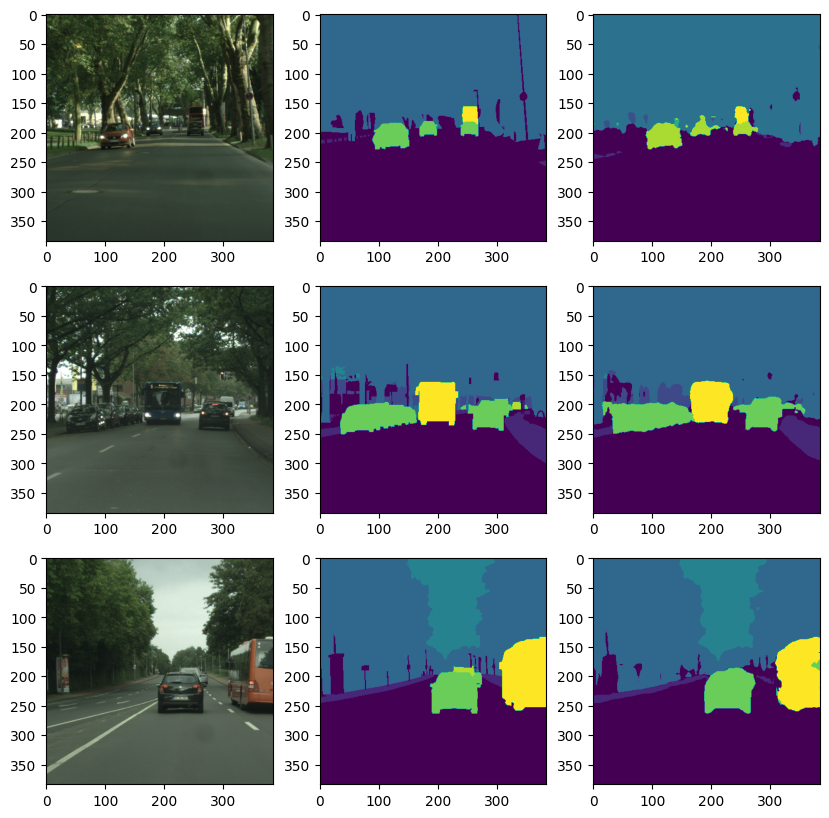

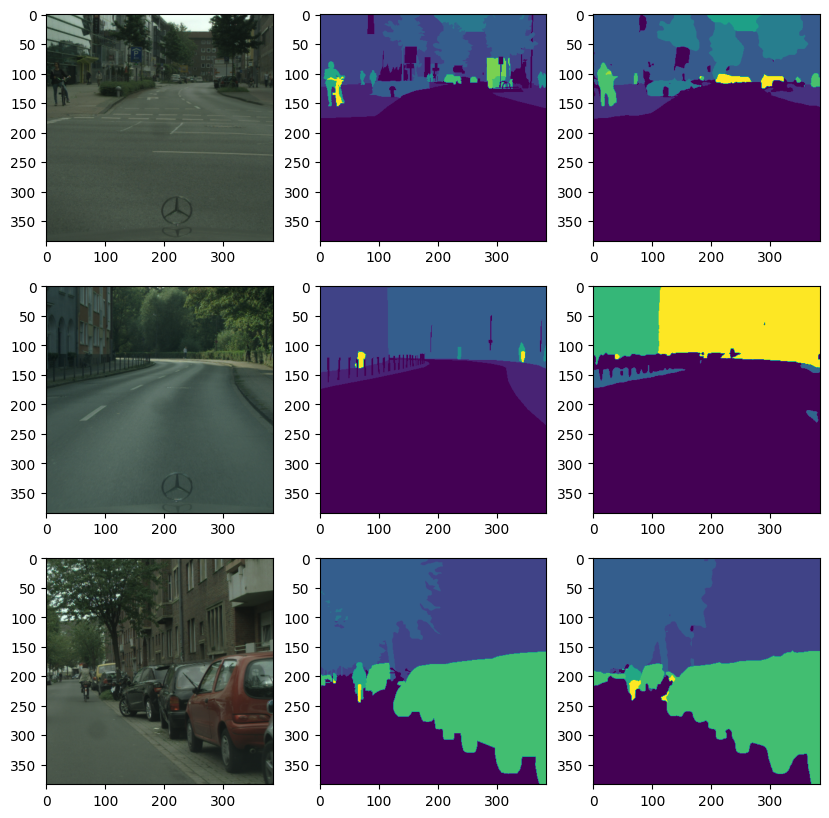

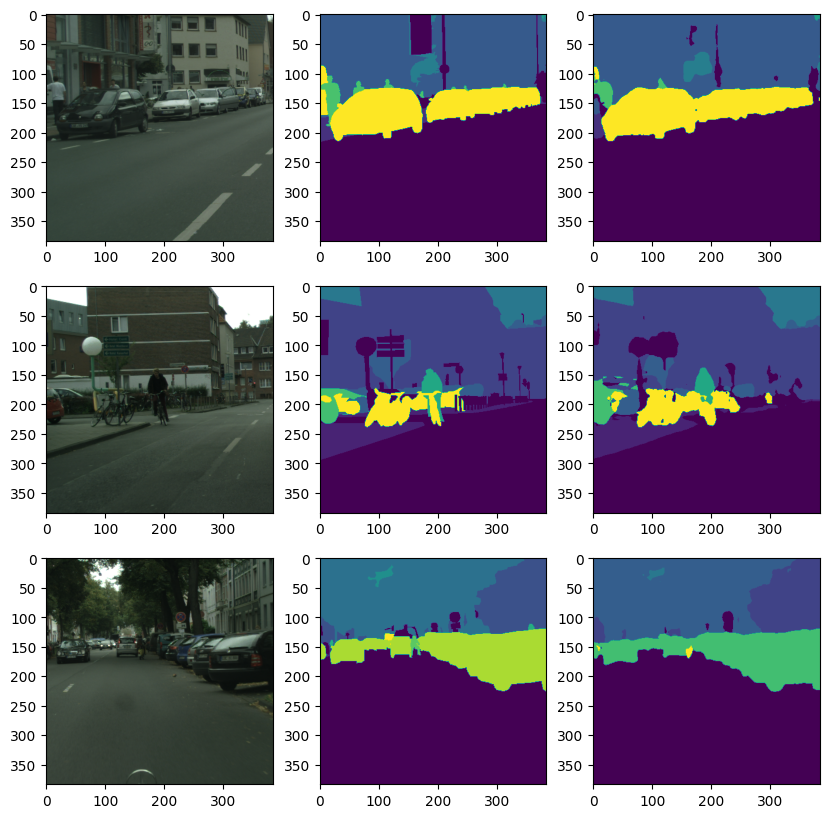

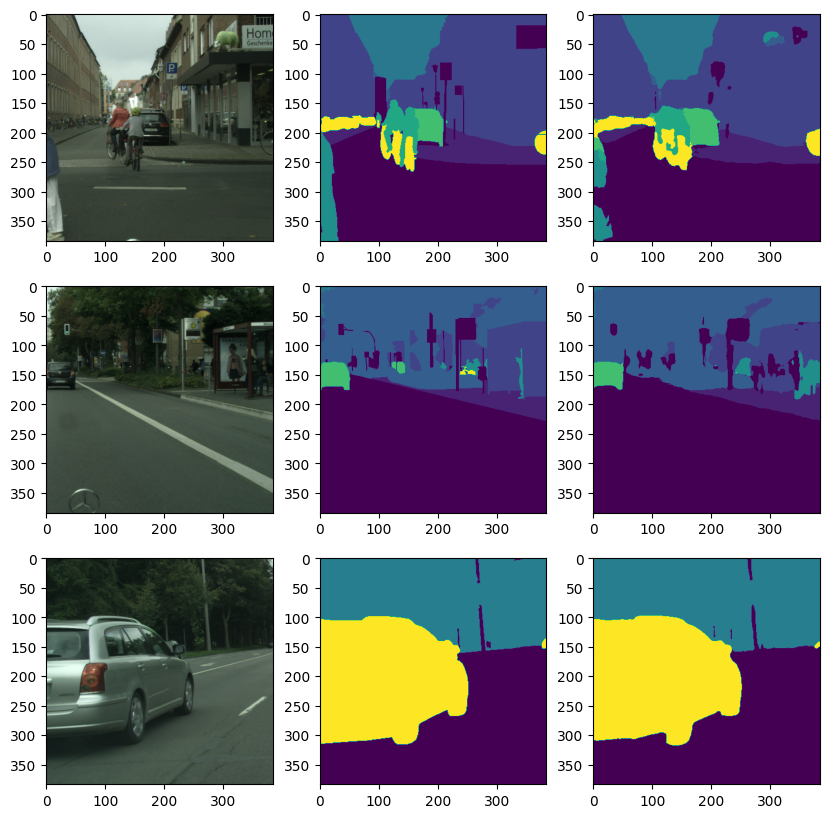

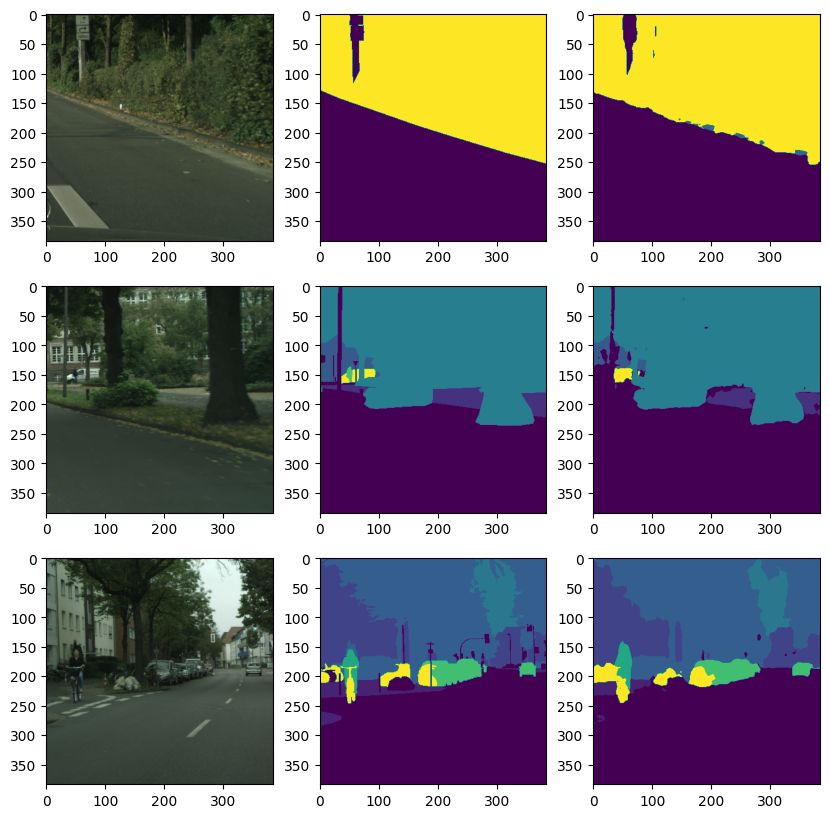

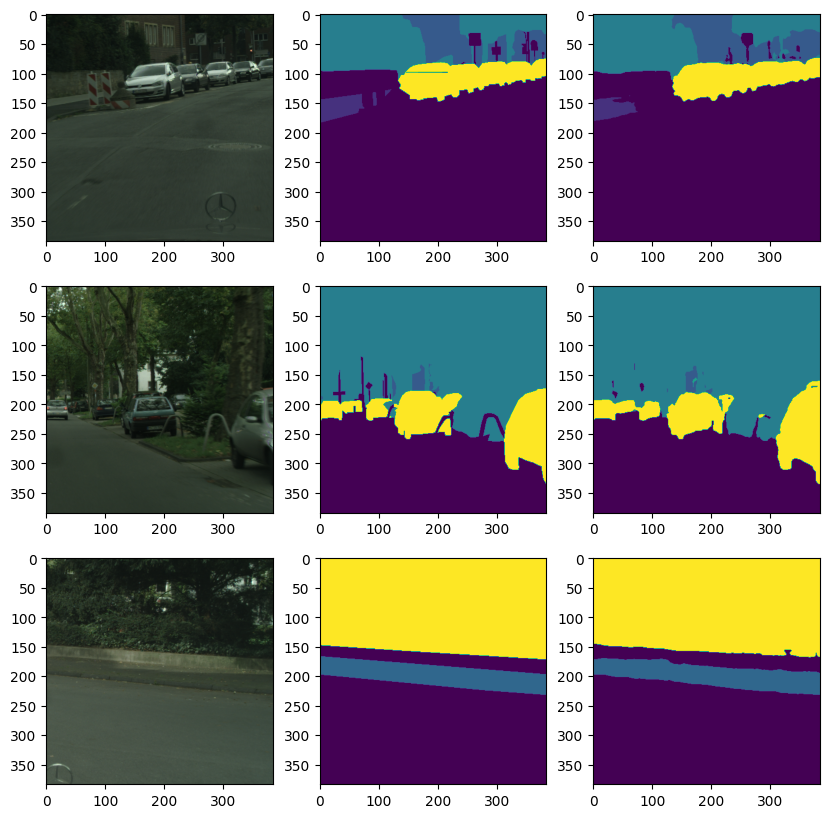

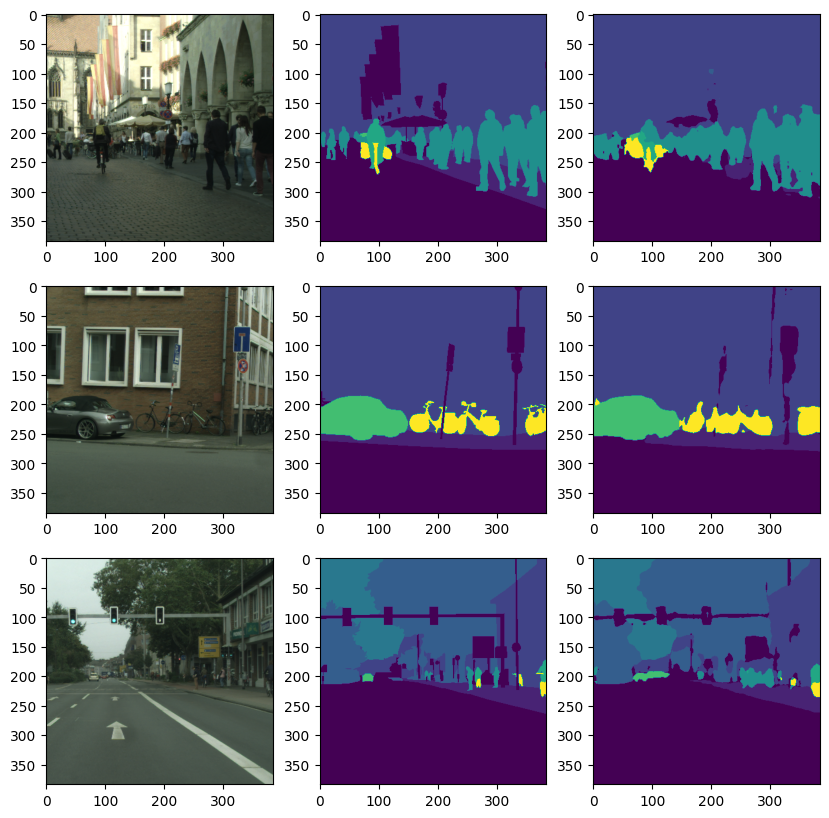

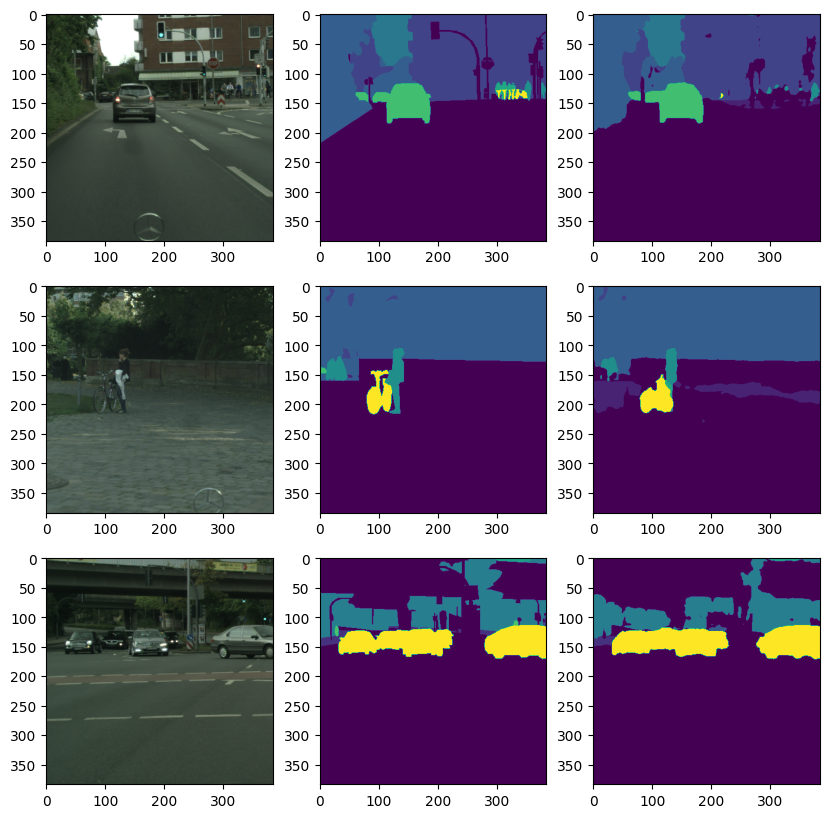

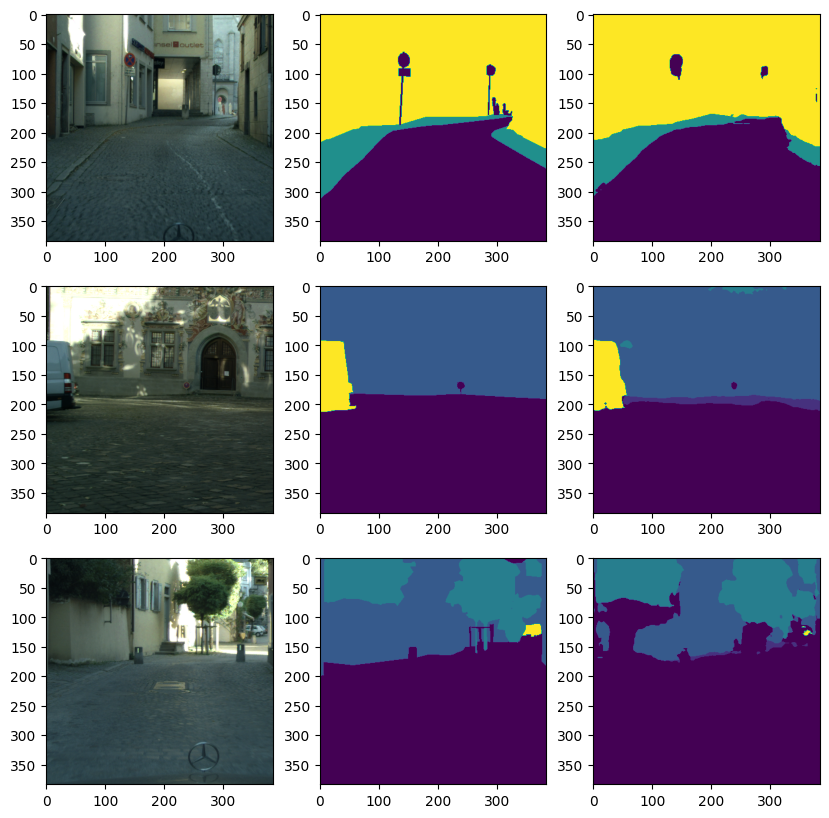

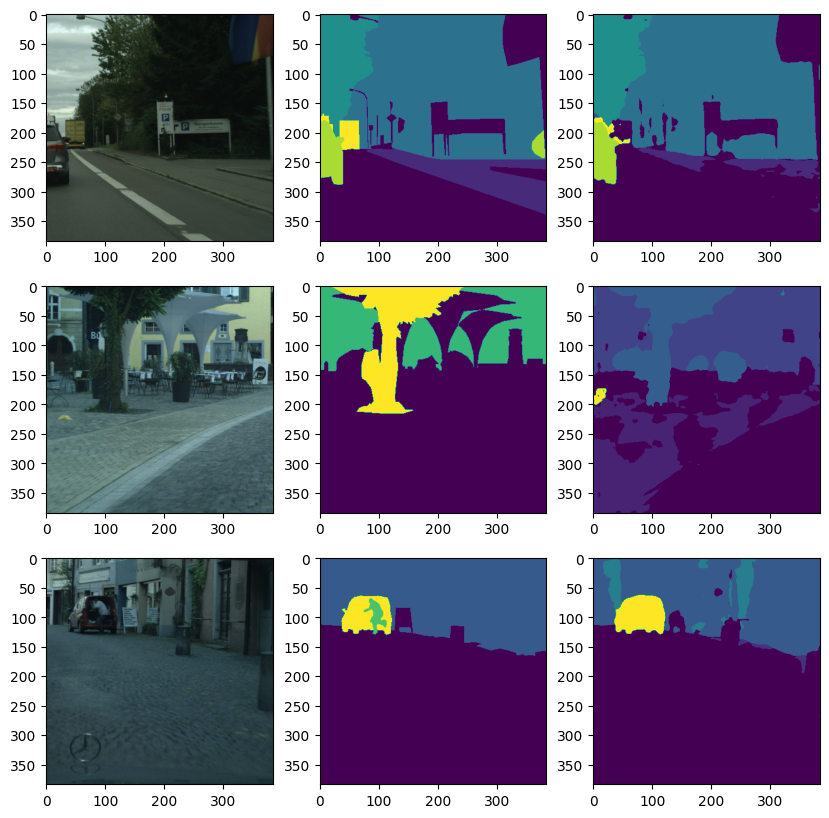

In [12]:
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.metrics import MeanIoU, Accuracy, Precision, Recall

miou_metric = MeanIoU(num_classes=19)
accuracy_metric = Accuracy()
precision_metric = Precision()
recall_metric = Recall()

model.save_weights('path_to_my_weights.h5')
model.load_weights('path_to_my_weights.h5')

num = 3
for image, mask in dataset_val.take(10):
    pred_mask = model.predict(image)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    miou_metric.update_state(mask, pred_mask)
    accuracy_metric.update_state(mask, pred_mask)
    precision_metric.update_state(mask, pred_mask)
    recall_metric.update_state(mask, pred_mask)

    plt.figure(figsize=(10, 10))
    for i in range(num):
        plt.subplot(num, 3, i*num+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image[i]))
        plt.subplot(num, 3, i*num+2)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[i]))
        plt.subplot(num, 3, i*num+3)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask[i]))

miou = miou_metric.result().numpy()
accuracy = accuracy_metric.result().numpy()
precision = precision_metric.result().numpy()
recall = recall_metric.result().numpy()

print("Mean IoU: ", miou)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)

1/1 [==============================] - 0s 100ms/step
Mean IoU:  0.77299446
Accuracy:  0.93997544
Precision:  0.9548067
Recall:  0.9646283


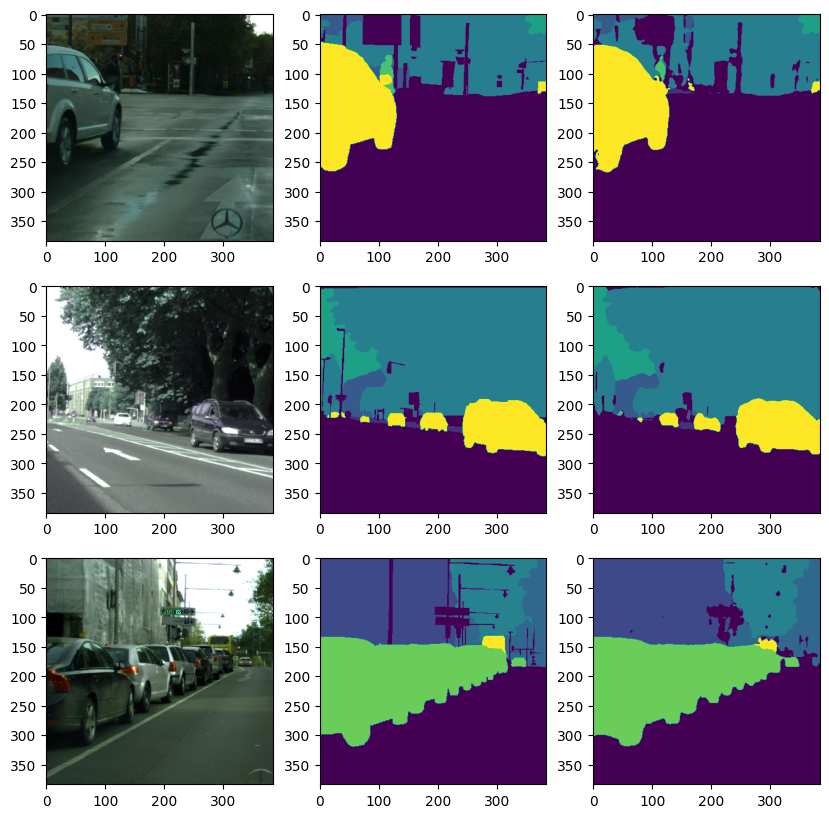

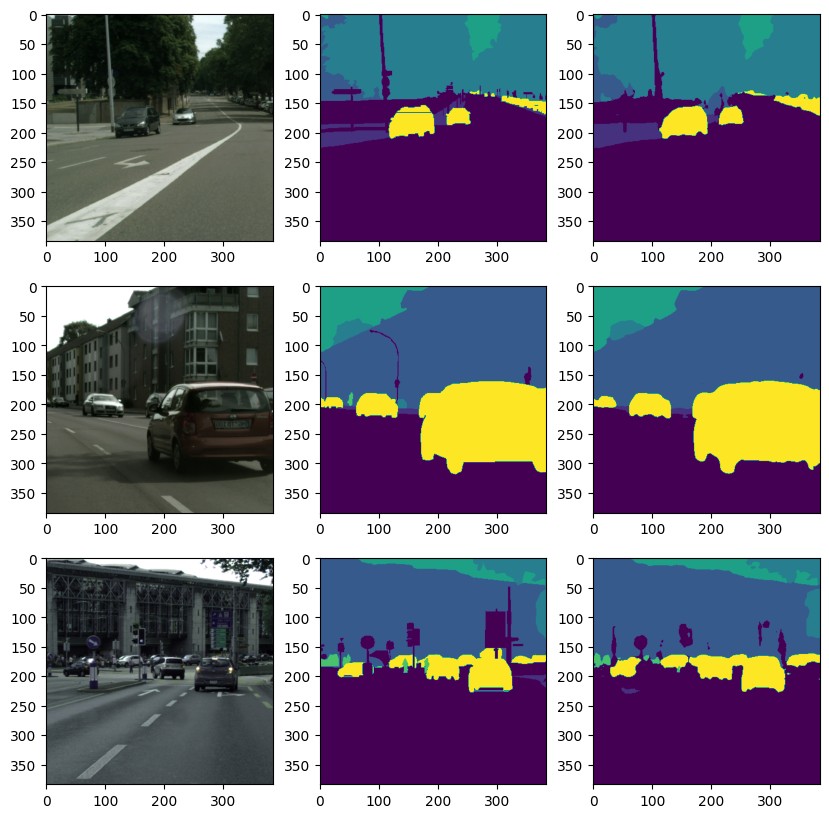

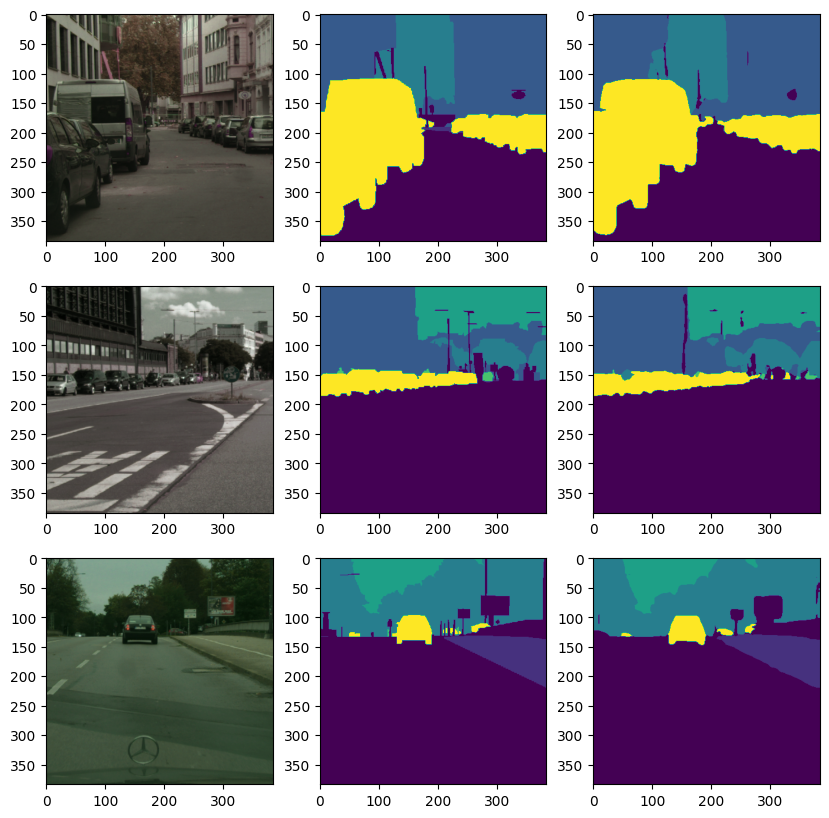

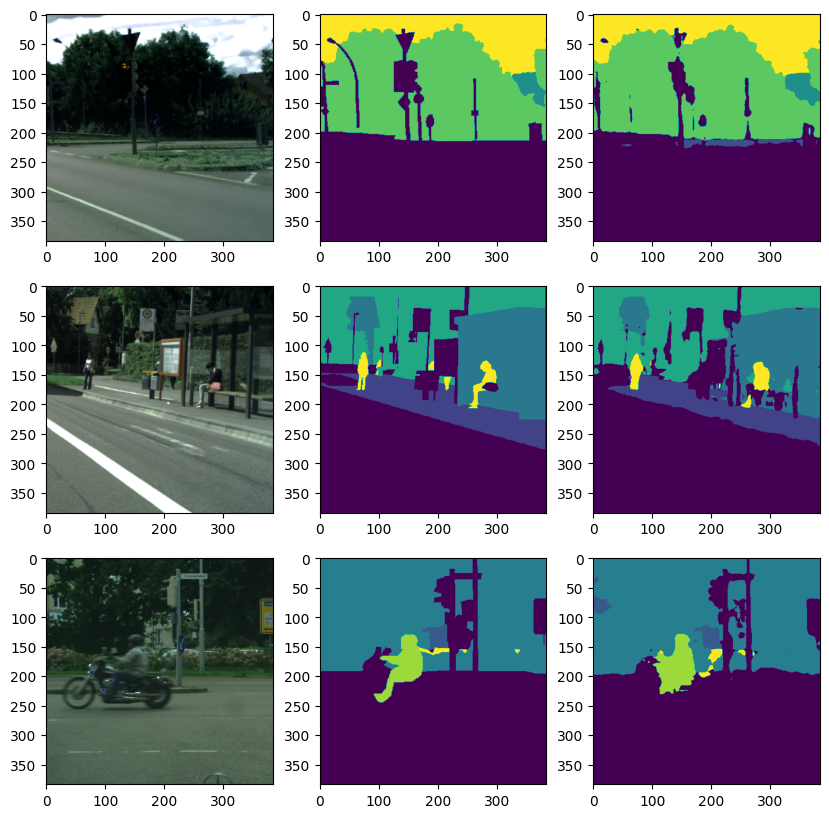

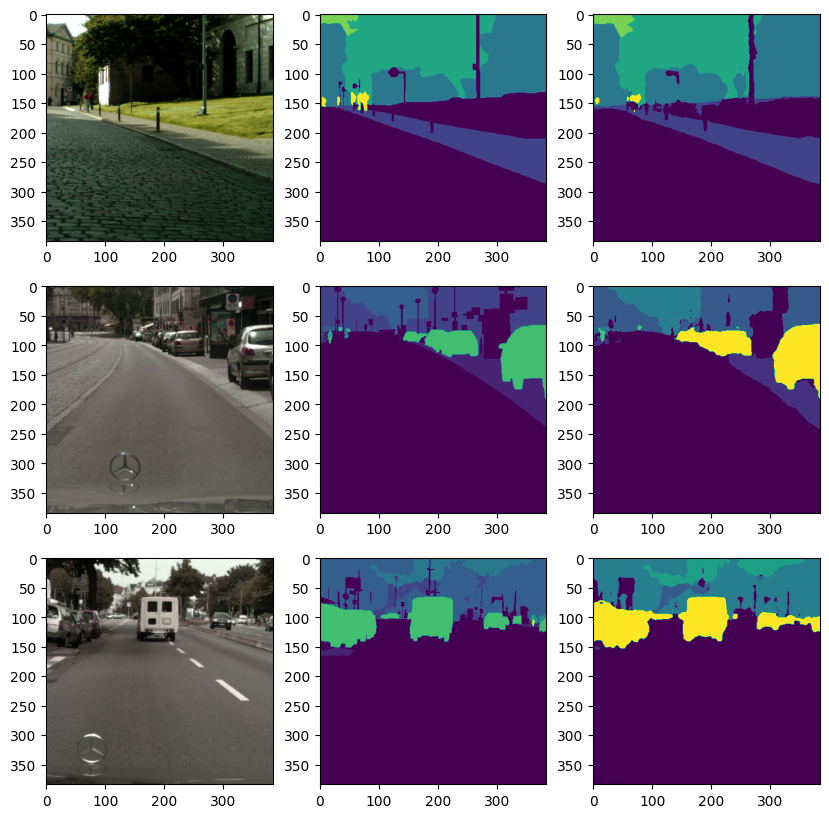

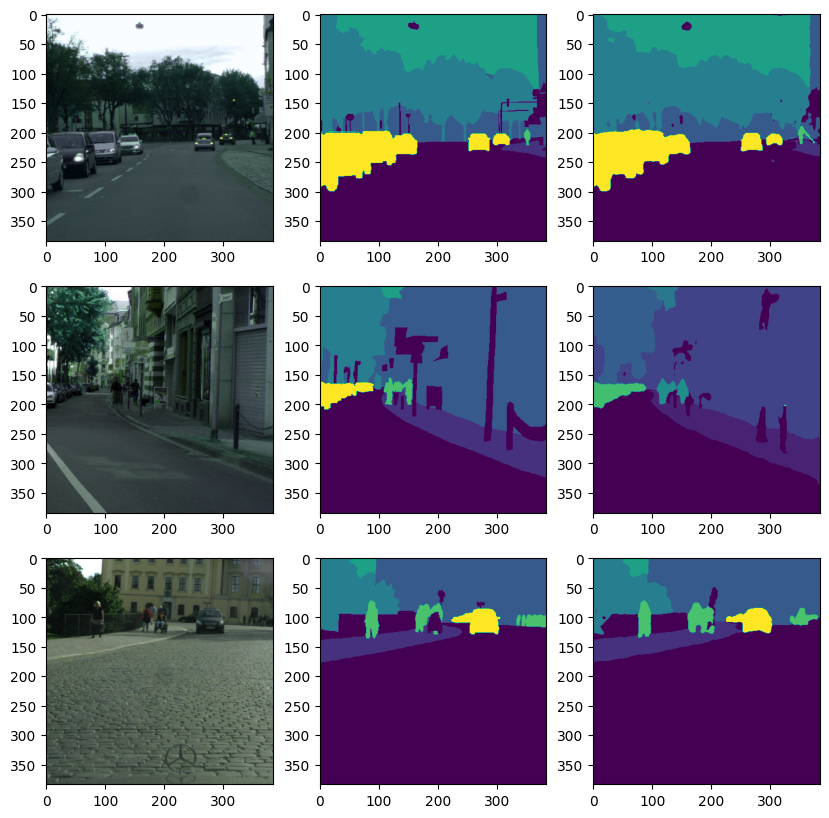

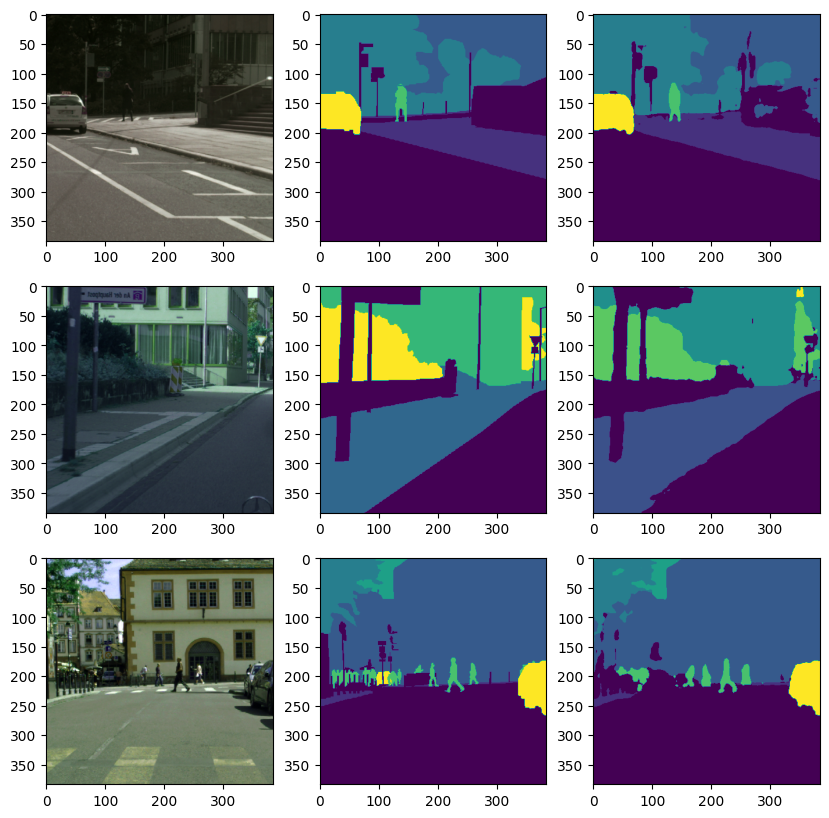

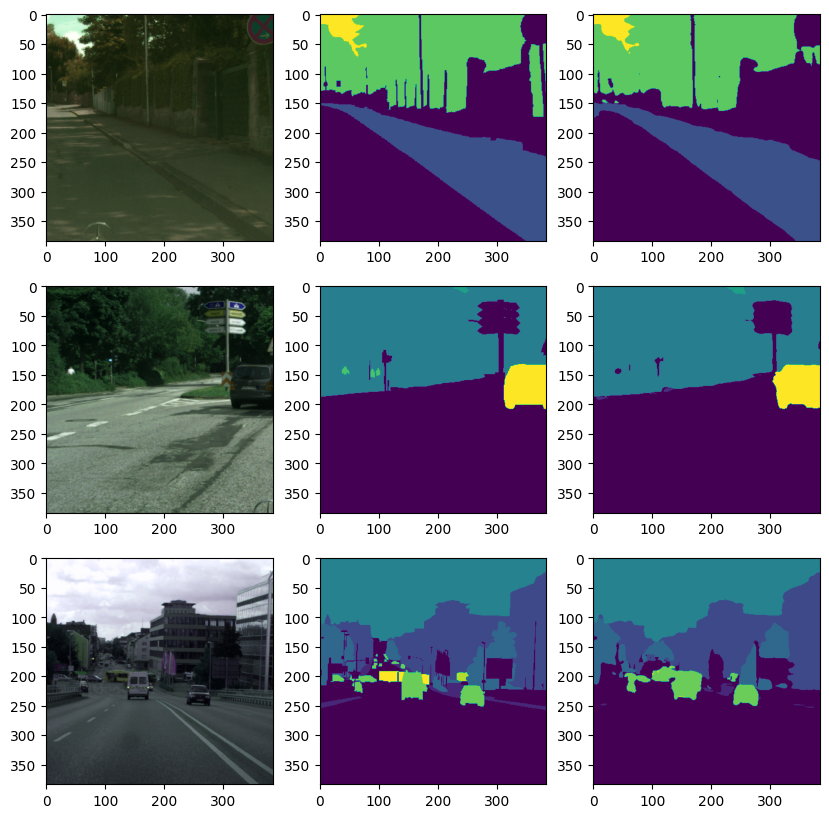

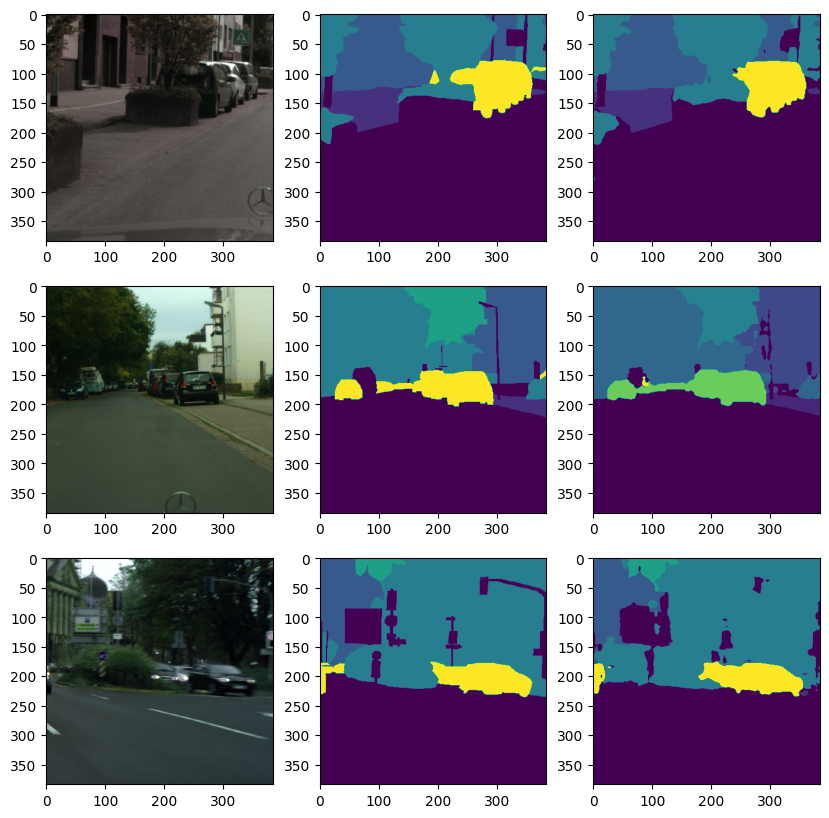

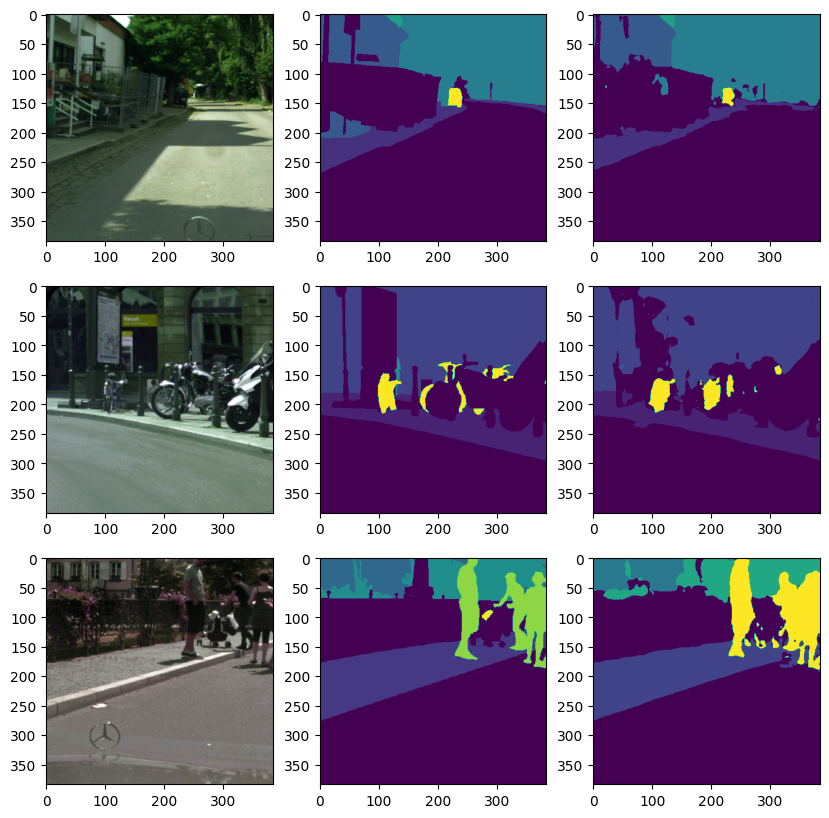

In [13]:
num = 3
for image, mask in dataset_train.take(10):
    pred_mask = model.predict(image)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    
    miou_metric.update_state(mask, pred_mask)
    accuracy_metric.update_state(mask, pred_mask)
    precision_metric.update_state(mask, pred_mask)
    recall_metric.update_state(mask, pred_mask)

    plt.figure(figsize=(10, 10))
    for i in range(num):
        plt.subplot(num, 3, i*num+1)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(image[i]))
        plt.subplot(num, 3, i*num+2)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(mask[i]))
        plt.subplot(num, 3, i*num+3)
        plt.imshow(tf.keras.preprocessing.image.array_to_img(pred_mask[i]))

miou = miou_metric.result().numpy()
accuracy = accuracy_metric.result().numpy()
precision = precision_metric.result().numpy()
recall = recall_metric.result().numpy()

print("Mean IoU: ", miou)
print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)